This notebook provides examples to go along with the [textbook](http://underactuated.csail.mit.edu/simple_legs.html).  I recommend having both windows open, side-by-side!

[Click here](http://underactuated.csail.mit.edu/drake.html#notebooks) for instructions on how to run the notebook on Deepnote and/or Google Colab.

In [3]:
import copy

import matplotlib.pyplot as plt
#import mpld3
import numpy as np
from IPython.display import display
from pydrake.all import (BasicVector, ConstantVectorSource, DiagramBuilder,
                         LeafSystem, LogVectorOutput, MeshcatVisualizerCpp,
                         PortDataType, PublishEvent, PyPlotVisualizer,
                         SceneGraph, Simulator, StartMeshcat,
                         UnrestrictedUpdateEvent, WitnessFunctionDirection,
                         namedview)
from pydrake.examples.compass_gait import CompassGait, CompassGaitGeometry
from pydrake.examples.rimless_wheel import (RimlessWheel, RimlessWheelGeometry,
                                            RimlessWheelParams)

from underactuated import running_as_notebook
from underactuated.jupyter import AdvanceToAndVisualize

#if running_as_notebook:
#    mpld3.enable_notebook()


In [4]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# The Rimless Wheel

In [ ]:
def rimless_wheel(slope=0.08, initial_angle=0, initial_angular_velocity=5.0):
    params = RimlessWheelParams()
    params.set_slope(slope)

    builder = DiagramBuilder()
    rimless_wheel = builder.AddSystem(RimlessWheel())
    scene_graph = builder.AddSystem(SceneGraph())
    RimlessWheelGeometry.AddToBuilder(
        builder, rimless_wheel.get_floating_base_state_output_port(), params,
        scene_graph)
    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    meshcat.Set2dRenderMode(xmin=-2, xmax=14, ymin=-2, ymax=3)

    diagram = builder.Build()
    simulator = Simulator(diagram)

    context = simulator.get_mutable_context()

    diagram.GetMutableSubsystemContext(
        rimless_wheel, context).get_numeric_parameter(0).set_slope(slope)
    context.SetAccuracy(1e-4)
    context.SetContinuousState([initial_angle, initial_angular_velocity])
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    visualizer.StartRecording()
    simulator.AdvanceTo(5.0 if running_as_notebook else 0.1)
    visualizer.PublishRecording()

rimless_wheel()

In [ ]:
rimless_wheel(initial_angular_velocity=5.0)

In [ ]:
rimless_wheel(initial_angular_velocity=10.0)

In [ ]:
rimless_wheel(initial_angular_velocity=0.95)

In [ ]:
rimless_wheel(initial_angular_velocity=-5.0)

In [ ]:
rimless_wheel(initial_angular_velocity=-4.8)

Here is a little interactive plot to allow you to visualize the trajectories of the rimless wheel as you vary the initial velocity.

In [ ]:
# TODO(russt): Port to meshcat and make it interactive, once again.

def rimless_wheel_return_map(initial_angular_velocity=1.5, duration=1.5):
    rimless_wheel = RimlessWheel()
    simulator = Simulator(rimless_wheel)
    context = simulator.get_mutable_context()
    params = context.get_numeric_parameter(0)
    qmin = params.slope() - rimless_wheel.calc_alpha(params) - 0.1
    qmax = params.slope() + rimless_wheel.calc_alpha(params) + 0.1
    qdmin = -2
    qdmax = 2

    context.SetAccuracy(1e-2)
    integrator = simulator.get_mutable_integrator()

    fig, ax = plt.subplots(figsize=(10,6))

    # TODO(russt): make the slope interactive, too.
    def simulate(initial_angular_velocity=1.5, duration=1.5):
        rimless_wheel.SetDefaultContext(context)
        context.SetTime(0.0)
        if initial_angular_velocity >= 0:
            initial_angle = params.slope() - rimless_wheel.calc_alpha(params)
        else:
            initial_angle = params.slope() + rimless_wheel.calc_alpha(params)
        if initial_angular_velocity == 0:
            # Set double_support = True.
            context.get_mutable_abstract_state(0).set_value(True)
            
        context.SetContinuousState([initial_angle, initial_angular_velocity])

        integrator.StartDenseIntegration()
        simulator.Initialize()
        simulator.AdvanceTo(duration if running_as_notebook else 0.1)
        pp = integrator.StopDenseIntegration()

        return pp.vector_values(pp.get_segment_times())

    if False:
        data = simulate()
        line, = ax.plot(data[0,:], data[1,:],'b')
        pt, = ax.plot(data[0,0], data[1,0],'b*', markersize=12)
        
        def update(initial_angular_velocity):
            data = simulate(initial_angular_velocity)
            line.set_xdata(data[0,:])
            line.set_ydata(data[1,:])
            pt.set_xdata(data[0,0])
            pt.set_ydata(data[1,0])
            fig.canvas.draw()
        
        interact(update, initial_angular_velocity=widgets.FloatSlider(min=qdmin, max=qdmax, step=.1, value=1.1))

    else:
        data = simulate(initial_angular_velocity, duration)
        ax.plot(data[0,:], data[1,:],'b')
        ax.plot(data[0,0], data[1,0],'b*', markersize=12)

    # Plot the energy contours.
    nq = 151
    nqd = 151
    mgl = params.mass() * params.gravity() * params.length()
    q = np.linspace(qmin, qmax, nq)
    qd = np.linspace(qdmin, qdmax, nqd)
    Q, QD = np.meshgrid(q, qd)
    Energy = .5 * params.mass() * params.length()**2 * QD**2 + mgl * np.cos(Q)
    ax.contour(Q,
            QD,
            Energy,
            alpha=0.5,
            linestyles="dashed",
            colors="black",
            linewidths=0.5)

    ax.plot(params.slope() - rimless_wheel.calc_alpha(params)*np.array([1, 1]), np.array([0, qdmax]), 'k--')
    ax.plot(params.slope() - rimless_wheel.calc_alpha(params)*np.array([1, 1]), np.array([0, qdmin]), 'k', linewidth=.25)
    ax.plot(params.slope() + rimless_wheel.calc_alpha(params)*np.array([1, 1]), np.array([0, qdmin]), 'k--')
    ax.plot(params.slope() + rimless_wheel.calc_alpha(params)*np.array([1, 1]), np.array([0, qdmax]), 'k', linewidth=.25)
    ax.plot([qmin, qmax], [0, 0], 'k', linewidth=.25)
    ax.plot([0, 0], [qdmin, qdmax], 'k', linewidth=.25)
    ax.set_xlabel("theta")
    ax.set_ylabel("thetadot")
    ax.axis([qmin, qmax, qdmin, qdmax])
    ax.set_title("Trajectories of the Rimless Wheel (w/ contours of "
                "constant energy)")
    display(mpld3.display())

# Interesting angular velocities to try: 5, 10, 0.95, -5, -4.8
rimless_wheel_return_map(initial_angular_velocity=-4.7, duration=5)

# The Compass Gait

In [ ]:
def compass_gait():
    builder = DiagramBuilder()
    compass_gait = builder.AddSystem(CompassGait())

    hip_torque = builder.AddSystem(ConstantVectorSource([0.0]))
    builder.Connect(hip_torque.get_output_port(0), compass_gait.get_input_port(0))

    scene_graph = builder.AddSystem(SceneGraph())
    CompassGaitGeometry.AddToBuilder(
        builder, compass_gait.get_floating_base_state_output_port(), scene_graph)
    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph,
                                                   meshcat)
    meshcat.Set2dRenderMode(xmin=-1, xmax=5, ymin=-1, ymax=2)

    logger = LogVectorOutput(compass_gait.get_output_port(1), builder)

    diagram = builder.Build()
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)

    context = simulator.get_mutable_context()
    context.SetAccuracy(1e-4)
    context.SetContinuousState([0., 0., 0.4, -2.])

    visualizer.StartRecording()
    simulator.AdvanceTo(8.0)
    visualizer.PublishRecording()
    log = logger.FindLog(context)
    plt.figure()
    plt.plot(log.data()[4, :], log.data()[11, :])
    plt.xlabel("left leg angle")
    plt.ylabel("left leg angular velocity")
    display(mpld3.display())

compass_gait()

# The Spring-Loaded Inverted Pendulum (SLIP)

In [17]:
SLIPState = namedview(
    "SLIPState", ["x", "z", "r", "theta", "xdot", "zdot", "rdot", "thetadot"])

class SpringLoadedInvertedPendulum(LeafSystem):

    def __init__(self):
        LeafSystem.__init__(self)

        self.DeclareVectorInputPort("touchdown_angle", BasicVector(1))
        self.DeclareContinuousState(BasicVector(np.zeros(8)), 4, 4, 0)

        self.DeclareVectorOutputPort("state", BasicVector(8), self.CopyStateOut)

        # Parameters from Geyer05, p.23
        self.mass = 80.  # kg
        self.r0 = 5.  # m
        self.gravity = 9.81  # m/s^2
        # Define spring constant in terms of the dimensionless number.
        # Definition in section 2.4.3, values in figure 2.4.
        # Note: Geyer05 says 10.8 (which doesn't work? -- I get no fixed pts).
        dimensionless_spring_constant = 10.7
        self.stiffness = (dimensionless_spring_constant * self.mass *
                          self.gravity / self.r0)

        self.last_apex = None  # placeholder for writing return map result.

        self.touchdown_witness = self.MakeWitnessFunction(
            "touchdown", WitnessFunctionDirection.kPositiveThenNonPositive,
            self.foot_height, UnrestrictedUpdateEvent(self.touchdown))
        self.takeoff_witness = self.MakeWitnessFunction(
            "takeoff", WitnessFunctionDirection.kPositiveThenNonPositive,
            self.leg_compression, UnrestrictedUpdateEvent(self.takeoff))
        self.apex_witness = self.MakeWitnessFunction(
            "apex", WitnessFunctionDirection.kPositiveThenNonPositive,
            self.apex, PublishEvent(self.publish_apex))

    def foot_height(self, context):
        s = SLIPState(context.get_continuous_state_vector().CopyToVector())
        return s.z - self.r0 * np.cos(s.theta)

    def touchdown(self, context, event, state):
        s = SLIPState(
            context.get_mutable_continuous_state_vector().CopyToVector())

        # print("touchdown")

        # Update rdot and thetadot to match xdot and ydot, using
        # x = -r*sin(theta), z = r*cos(theta)
        #  => xdot = -rdot*s - r*c*thetadot, zdot = rdot*c - r*s*thetadot
        #  => xdot*c + zdot*s = -r*thetadot
        # r^2 = x^2 + z^2
        #  => 2r*rdot = 2x*xdot + 2z*zdot
        #  => rdot = -xdot*sin(theta) + zdot*cos(theta)
        # (matches Geyer05 Eq. 2.24 up to the symbol changes)
        s.r = self.r0
        s.rdot = -s.xdot * np.sin(s.theta) + s.zdot * np.cos(s.theta)
        s.thetadot = -(s.xdot * np.cos(s.theta) +
                       s.zdot * np.sin(s.theta)) / self.r0
        state.get_mutable_continuous_state().get_mutable_vector().SetFromVector(
            s[:])

    def leg_compression(self, context):
        s = SLIPState(context.get_continuous_state_vector().CopyToVector())
        return self.r0 - s.r

    def takeoff(self, context, event, state):
        s = SLIPState(
            context.get_mutable_continuous_state_vector().CopyToVector())

        # print("takeoff")

        # Setup flight state (these lines aren't strictly required, since we
        # choose to also integrate x and z in stance below).
        s.z = self.r0 * np.cos(s.theta)
        s.xdot = -s.rdot * np.sin(s.theta) - self.r0 * s.thetadot * np.cos(
            s.theta)
        s.zdot = s.rdot * np.cos(s.theta) - self.r0 * s.thetadot * np.sin(
            s.theta)

        # Update theta to commanded leg angle.
        s.theta = self.EvalVectorInput(context, 0).GetAtIndex(0)
        s.thetadot = 0
        s.r = self.r0
        s.rdot = 0

        state.get_mutable_continuous_state().get_mutable_vector().SetFromVector(
            s[:])

    def apex(self, context):
        return context.get_continuous_state_vector().GetAtIndex(5)  # zdot

    def publish_apex(self, context, event):
        # TODO(russt): provide an option to terminate here instead, pending
        # resolution of #4447.
        # print("apex")
        if self.last_apex is None:
            s = SLIPState(
                context.get_mutable_continuous_state_vector().CopyToVector())
            self.last_apex = s.z

    def apex_velocity_from_dimensionless_system_energy(self, Etilde, z):
        E = Etilde * self.mass * self.gravity * self.r0
        # E = 0.5*m*v^2 + m*g*z
        xdot = np.sqrt(2. / self.mass * (E - self.mass * self.gravity * z))
        return xdot

    def energy_flight(self, context):
        s = SLIPState(
            context.get_mutable_continuous_state_vector().CopyToVector())
        return (0.5 * self.mass * (s.xdot**2 + s.zdot**2) +
                self.mass * self.gravity * s.z)

    def energy_stance(self, context):
        s = SLIPState(
            context.get_mutable_continuous_state_vector().CopyToVector())
        return (0.5 * self.mass * (s.rdot**2 + s.r**2 * s.thetadot**2) +
                self.mass * self.gravity * s.r * np.cos(s.theta) +
                0.5 * self.stiffness * (self.r0 - s.r)**2)

    def CopyStateOut(self, context, output):
        x = context.get_continuous_state_vector().CopyToVector()
        y = output.SetFromVector(x)

    def DoGetWitnessFunctions(self, context):
        return [self.touchdown_witness, self.takeoff_witness, self.apex_witness]

    def DoCalcTimeDerivatives(self, context, derivatives):
        s = SLIPState(context.get_continuous_state_vector().CopyToVector())
        sdot = SLIPState(np.zeros(8))
        sdot[0:4] = s[4:8]

        if (self.foot_height(context) < 0):
            # then we're in "stance"
            sdot.rdot = (self.stiffness / self.mass * (self.r0 - s.r) +
                         s.r * s.thetadot**2 - self.gravity * np.cos(s.theta))
            sdot.thetadot = (self.gravity / s.r * np.sin(s.theta) -
                             2 * s.rdot * s.thetadot / s.r)

            # Integrate x and z also, just for the sake of visualization (all
            # the integrated values except x will be overwritten in the
            # take-off reset).
            # x = -r*sin(theta), y = r*cos(theta) =>
            sdot.xdot = (-sdot.rdot * np.sin(s.theta) -
                         2 * s.rdot * s.thetadot * np.cos(s.theta) +
                         s.r * s.thetadot**2 * np.sin(s.theta) -
                         s.r * sdot.thetadot * np.cos(s.theta))
            sdot.zdot = (sdot.rdot * np.cos(s.theta) -
                         2 * s.rdot * s.thetadot * np.sin(s.theta) -
                         s.r * sdot.thetadot * np.sin(s.theta) -
                         s.r * s.thetadot**2 * np.cos(s.theta))

        else:
            sdot.xdot = 0
            sdot.zdot = -self.gravity
            sdot.rdot = 0
            sdot.thetadot = 0

        derivatives.get_mutable_vector().SetFromVector(sdot[:])


class SLIPVisualizer(PyPlotVisualizer):

    def __init__(self, ax=None, show=True):
        PyPlotVisualizer.__init__(self, ax=ax, show=show, figsize=(12,20))
        self.DeclareInputPort("slip_state", PortDataType.kVectorValued, 8)
        self.ax.set_aspect("equal")
        self.ax.set_xlim(0, 2)
        self.ax.set_ylim(-.1, 1.5)

        # Draw the ground.
        self.ax.plot([-50, 50], [0, 0], "k")

        a = np.linspace(0, 2 * np.pi, 50)
        radius = 0.1
        self.hip_fill = self.ax.fill(radius * np.sin(a),
                                     radius * np.cos(a),
                                     zorder=1,
                                     edgecolor="k",
                                     facecolor=[.6, .6, .6])
        self.hip = copy.copy(self.hip_fill[0].get_path().vertices)

        self.leg_line = [self.ax.plot([0, 0], [0, -1], "k")[0]]
        self.leg_data = [self.leg_line[0].get_xydata().T]
        for i in range(1, 13):
            self.leg_line.append(
                self.ax.plot(
                    0.1 * np.array(
                        [np.sin((i - 1) * np.pi / 2.),
                         np.sin(i * np.pi / 2.)]),
                    -.2 - .7 / 13 * np.array([i - 1, i]), "k")[0])
            self.leg_data.append(self.leg_line[i].get_xydata().T)

    def draw(self, context):
        state = SLIPState(self.EvalVectorInput(context, 0).CopyToVector())

        self.hip_fill[0].get_path().vertices[:, 0] = state.x + self.hip[:, 0]
        self.hip_fill[0].get_path().vertices[:, 1] = state.z + self.hip[:, 1]

        R = np.array([[np.cos(state.theta), -np.sin(state.theta)],
                      [np.sin(state.theta),
                       np.cos(state.theta)]])
        for i in range(len(self.leg_line)):
            self.leg_line[i].set_xdata(state.x +
                                       state.r * R[0, :].dot(self.leg_data[i]))
            self.leg_line[i].set_ydata(state.z +
                                       state.r * R[1, :].dot(self.leg_data[i]))

        self.ax.set_title("t = {:.1f}".format(context.get_time()))


In [18]:
def slip_demo():
    builder = DiagramBuilder()
    plant = builder.AddSystem(SpringLoadedInvertedPendulum())

    # Parameters from Geyer05, Figure 2.4
    # Note: Geyer uses angle of attack = 90 - touchdown_angle
    touchdown_angle = np.deg2rad(30)
    Etilde = 1.61

    s = SLIPState(np.zeros(8))
    s.z = 0.9
    s.theta = touchdown_angle
    s.r = 1
    s.xdot = plant.apex_velocity_from_dimensionless_system_energy(Etilde, s.z)

    visualizer = builder.AddSystem(SLIPVisualizer(show=False))
    builder.Connect(plant.get_output_port(0), visualizer.get_input_port(0))

    log = LogVectorOutput(plant.get_output_port(0), builder)

    command = builder.AddSystem(ConstantVectorSource([touchdown_angle]))
    builder.Connect(command.get_output_port(0), plant.get_input_port(0))

    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    context.SetAccuracy(1e-10)

    context.get_mutable_continuous_state_vector().SetFromVector(s[:])

    AdvanceToAndVisualize(simulator, visualizer, 2.0)

slip_demo()

simulating...  done.
generating animation...


## Apex-to-apex map

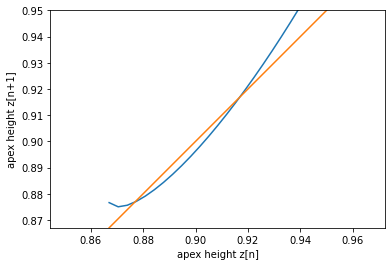

In [8]:
def slip_map():
    plant = SpringLoadedInvertedPendulum()

    # Parameters from Geyer05, Figure 2.4
    # Note: Geyer uses angle of attack = 90 - touchdown_angle
    touchdown_angle = np.deg2rad(30)
    Etilde = 1.61

    s = SLIPState(np.zeros(8))
    s.theta = touchdown_angle
    s.r = 1

    simulator = Simulator(plant)
    context = simulator.get_mutable_context()
    plant.get_input_port(0).FixValue(context, [touchdown_angle])
    context.SetAccuracy(1e-5)

    zs = np.linspace(np.cos(touchdown_angle) + 0.001, 0.95, 25)
    zns = 0 * zs
    for i in range(len(zs)):
        s.z = zs[i]
        s.xdot = plant.apex_velocity_from_dimensionless_system_energy(Etilde, s.z)
        context.SetTime(0.)
        context.get_mutable_continuous_state_vector().SetFromVector(s[:])
        simulator.Initialize()
        # Note: With this duration, I sometimes get an extra "touchdown" after the
        # apex, which results in apex-touchdown; touchdown-takeoff-apex on the
        # console.  It's not a double reset, the consecutive touchdowns are two
        # different sims.
        simulator.AdvanceTo(0.6)
        zns[i] = plant.last_apex
        plant.last_apex = None

    fig, ax = plt.subplots()
    ax.plot(zs, zns)
    ax.plot(zs, zs)
    ax.axis("equal")
    ax.set_xlim([zs[0], zs[-1]])
    ax.set_ylim([zs[0], zs[-1]])
    ax.set_xlabel("apex height z[n]")
    ax.set_ylabel("apex height z[n+1]")

    #display(mpld3.display())

slip_map()